In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import scanpy as sc
import numpy as np
import scnet as sn

Using TensorFlow backend.


In [4]:
sc.settings.set_figure_params(dpi=200)

In [5]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]
target_cell_types = ['Pancreas Alpha', 'Pancreas Gamma']

In [6]:
sc.settings.figdir = "./results/iterative_surgery_new/pancreas_alpha+gamma/"

# Loading 5 Pancreas datasets and data preparation

In [7]:
adata = sc.read("./data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [8]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

In [9]:
batch_colors = sc.pl.palettes.zeileis_28[:5]
batch_colors

['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784']

In [10]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
adata_for_training = adata_for_training[~adata_for_training.obs[cell_type_key].isin(target_cell_types)]
adata_for_training

View of AnnData object with n_obs × n_vars = 7291 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [12]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [13]:
train_adata, valid_adata = sn.utils.train_test_split(adata_for_training, 0.8)

In [14]:
train_adata.shape, valid_adata.shape

((5832, 1000), (1459, 1000))

In [15]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [16]:
network = sn.archs.CVAE(x_dimension=train_adata.shape[1], 
                        z_dimension=10,
                        architecture=[128, 20],
                        n_conditions=n_conditions,
                        use_batchnorm=False,
                        lr=0.001,
                        alpha=0.0001,
                        beta=200,
                        clip_value=1000,
                        eta=1.0,
                        loss_fn='mse',
                        model_path=f"./models/OoS+IS/pancreas/before/",
                        dropout_rate=0.05,
                        output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [17]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

## Training the network

In [18]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=10000,
              batch_size=512, 
              early_stop_limit=50,
              lr_reducer=40, 
              n_per_epoch=0,
              save=True,
              retrain=False,
              verbose=5)

Model has been successfully restored!


In [19]:
network.condition_encoder

{'Pancreas inDrop': 0, 'Pancreas CelSeq': 1, 'Pancreas Fluidigm C1': 2}

In [20]:
encoder_labels, _ = sn.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 7291 × 20 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [23]:
palette = ['#023fa5', '#bec1d4','#bb7784']

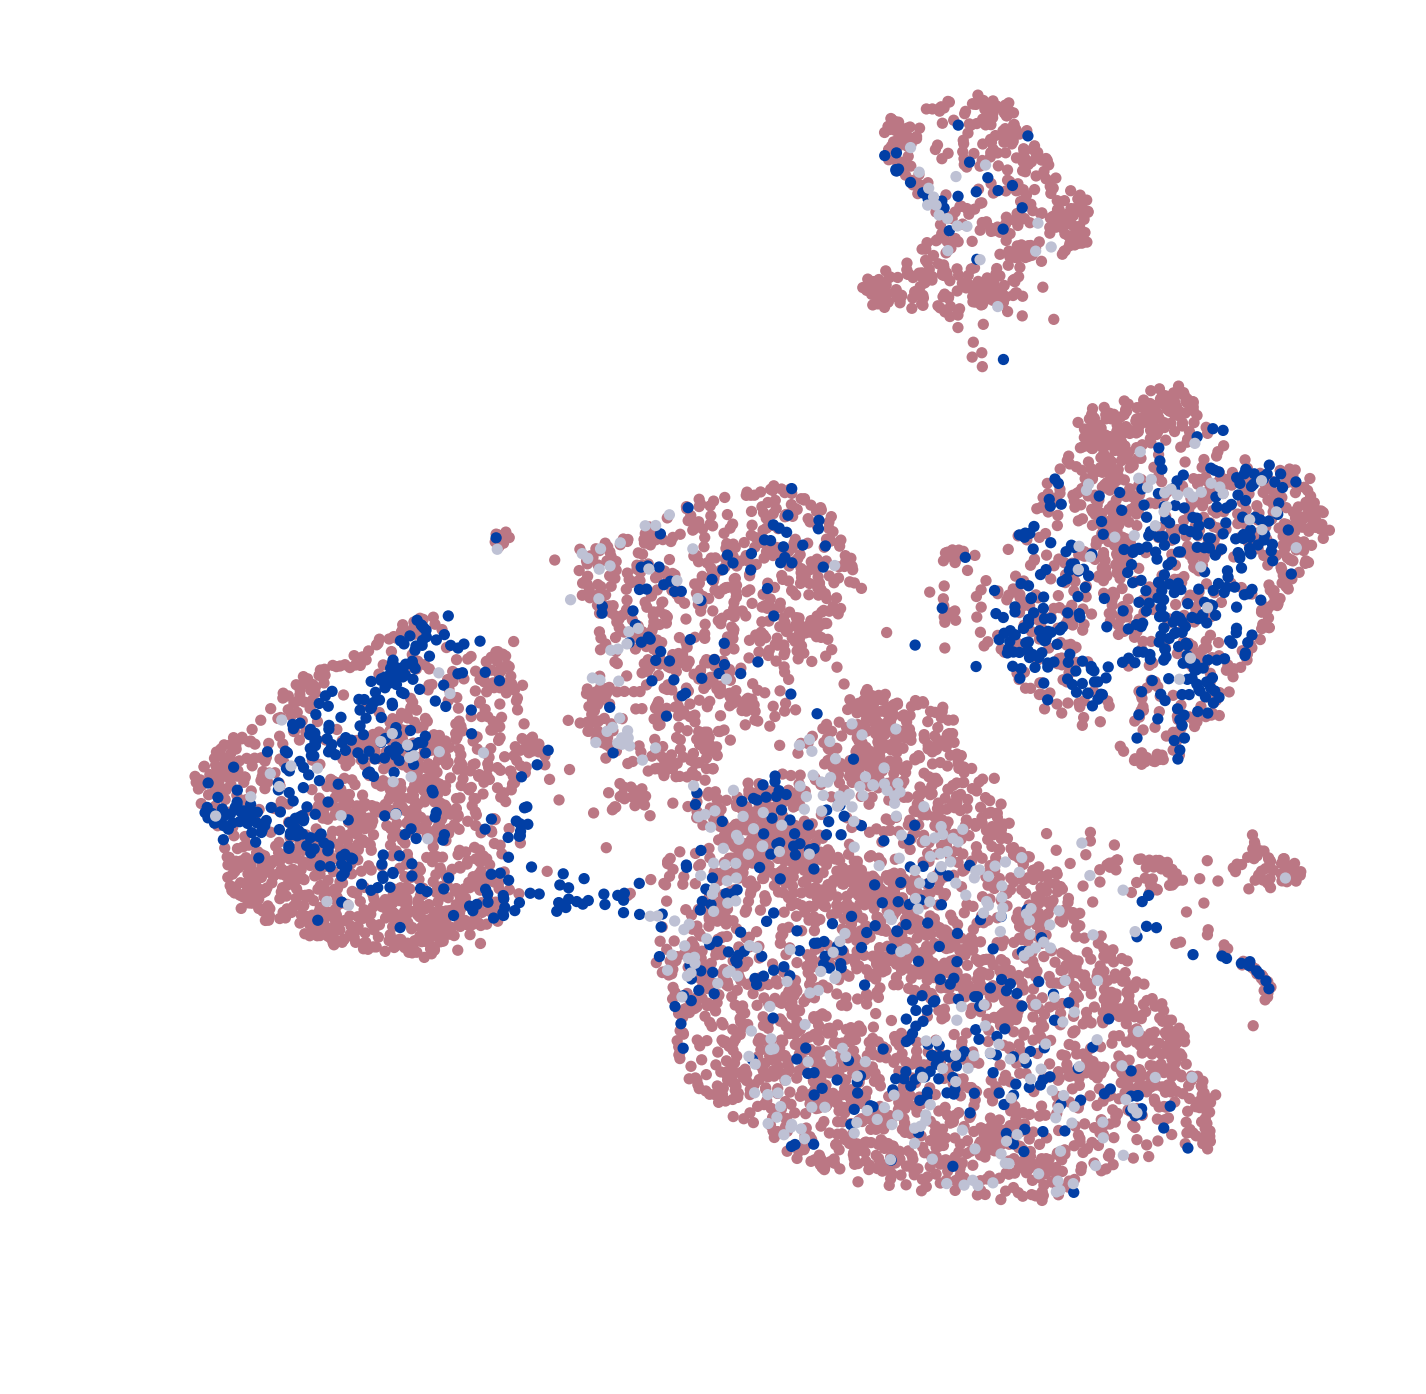

In [24]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", legend_loc=None,
           save="_condition_before.pdf", palette=palette)

In [25]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

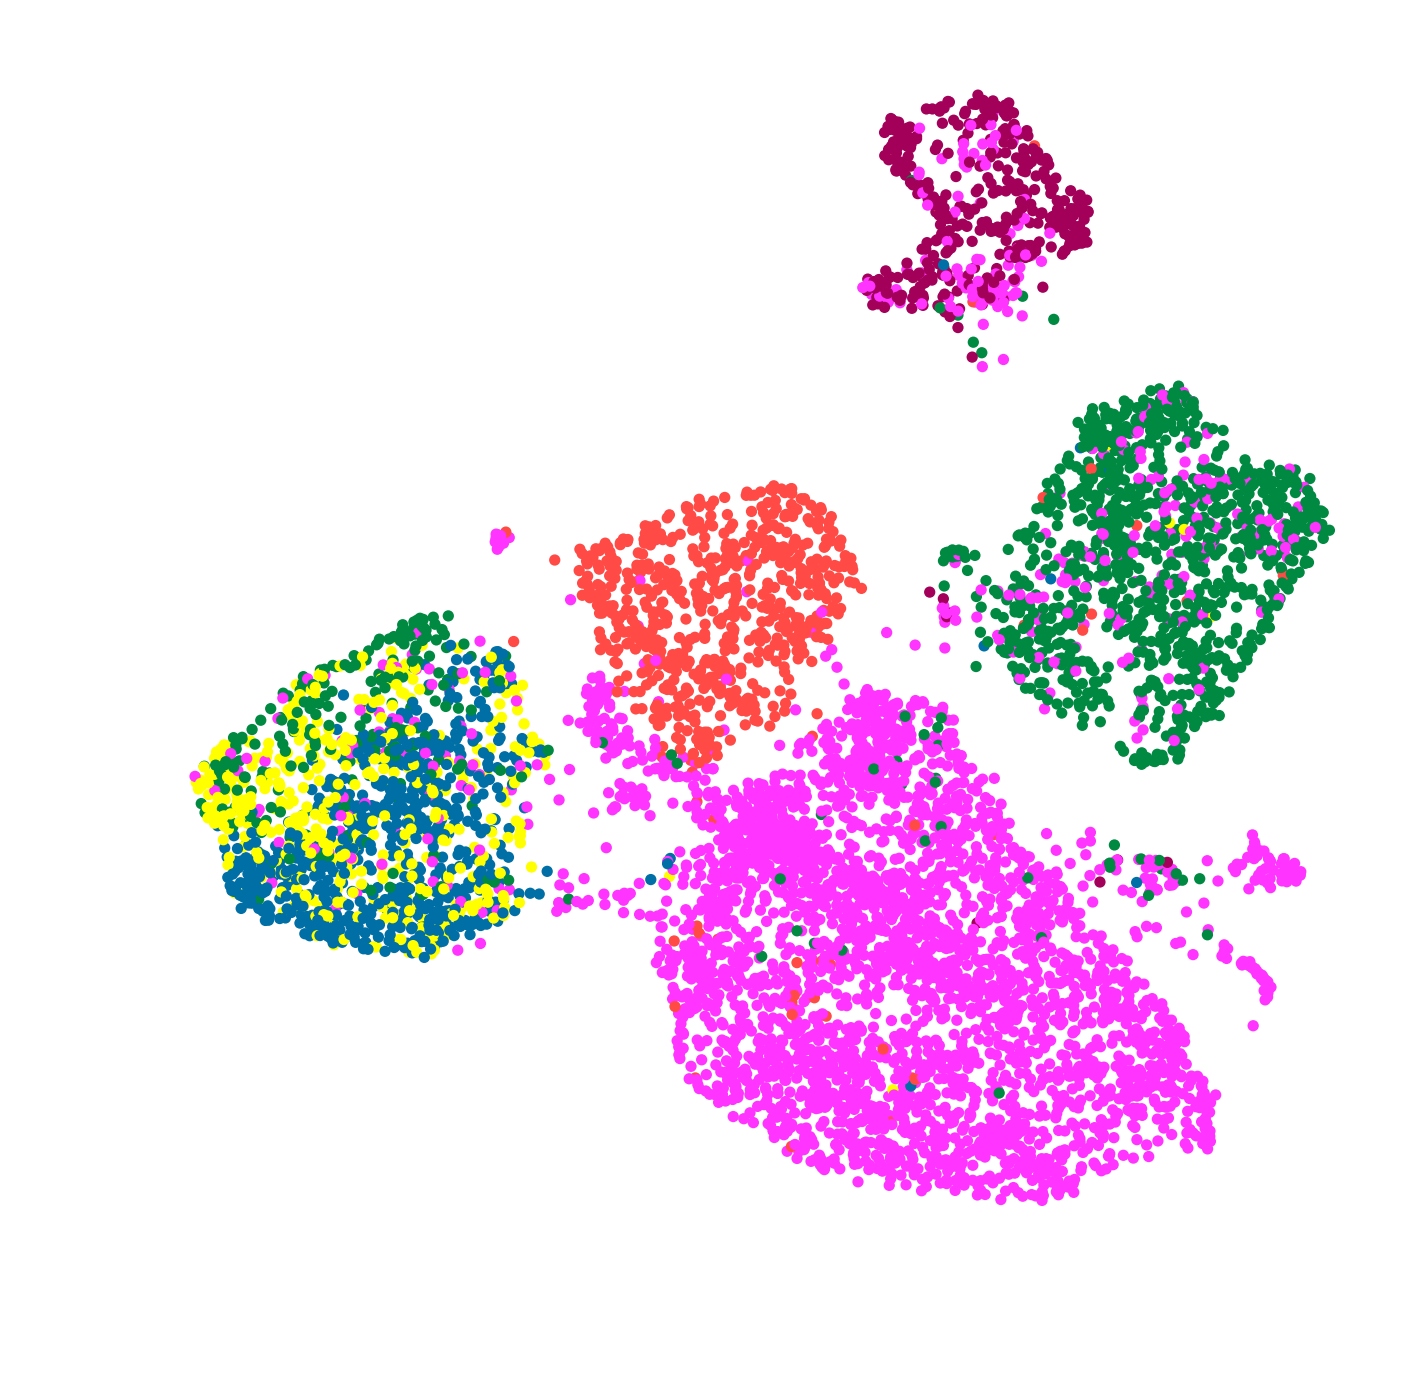

In [26]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", legend_loc=None,
           save="_cell_type_before.pdf", palette=palette)

# Perfroming architecture Surgery

In [27]:
new_network = sn.operate(network, 
                         new_conditions=target_conditions[0],
                         init='Xavier',
                         freeze_expression_input=True,
                         freeze=True,
                         remove_dropout=True,
                         )

In [28]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3}

## Train with small new dataset containing out-of-sample condition

In [29]:
target_adata = adata_out_of_sample[adata_out_of_sample.obs[condition_key] == target_conditions[0]]
target_adata

View of AnnData object with n_obs × n_vars = 2961 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [30]:
train_adata, valid_adata = sn.utils.train_test_split(target_adata, 0.8)

In [31]:
train_adata.shape, valid_adata.shape

((2368, 1000), (593, 1000))

In [32]:
new_network.model_path = f"./models/OoS+IS/pancreas/after-{target_conditions[0]}/"

In [33]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=128, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

Model has been successfully restored!


In [34]:
plot_adata = target_adata.concatenate(adata_for_training)

In [35]:
encoder_labels, _ = sn.utils.label_encoder(plot_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(10252, 1)

In [36]:
latent_adata_after = new_network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata_after

AnnData object with n_obs × n_vars = 10252 × 20 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [37]:
sc.pp.neighbors(latent_adata_after)
sc.tl.umap(latent_adata_after)

In [38]:
palette = ['#023fa5', '#bec1d4', '#7d87b9', '#bb7784']

... storing 'cell_type' as categorical
... storing 'study' as categorical


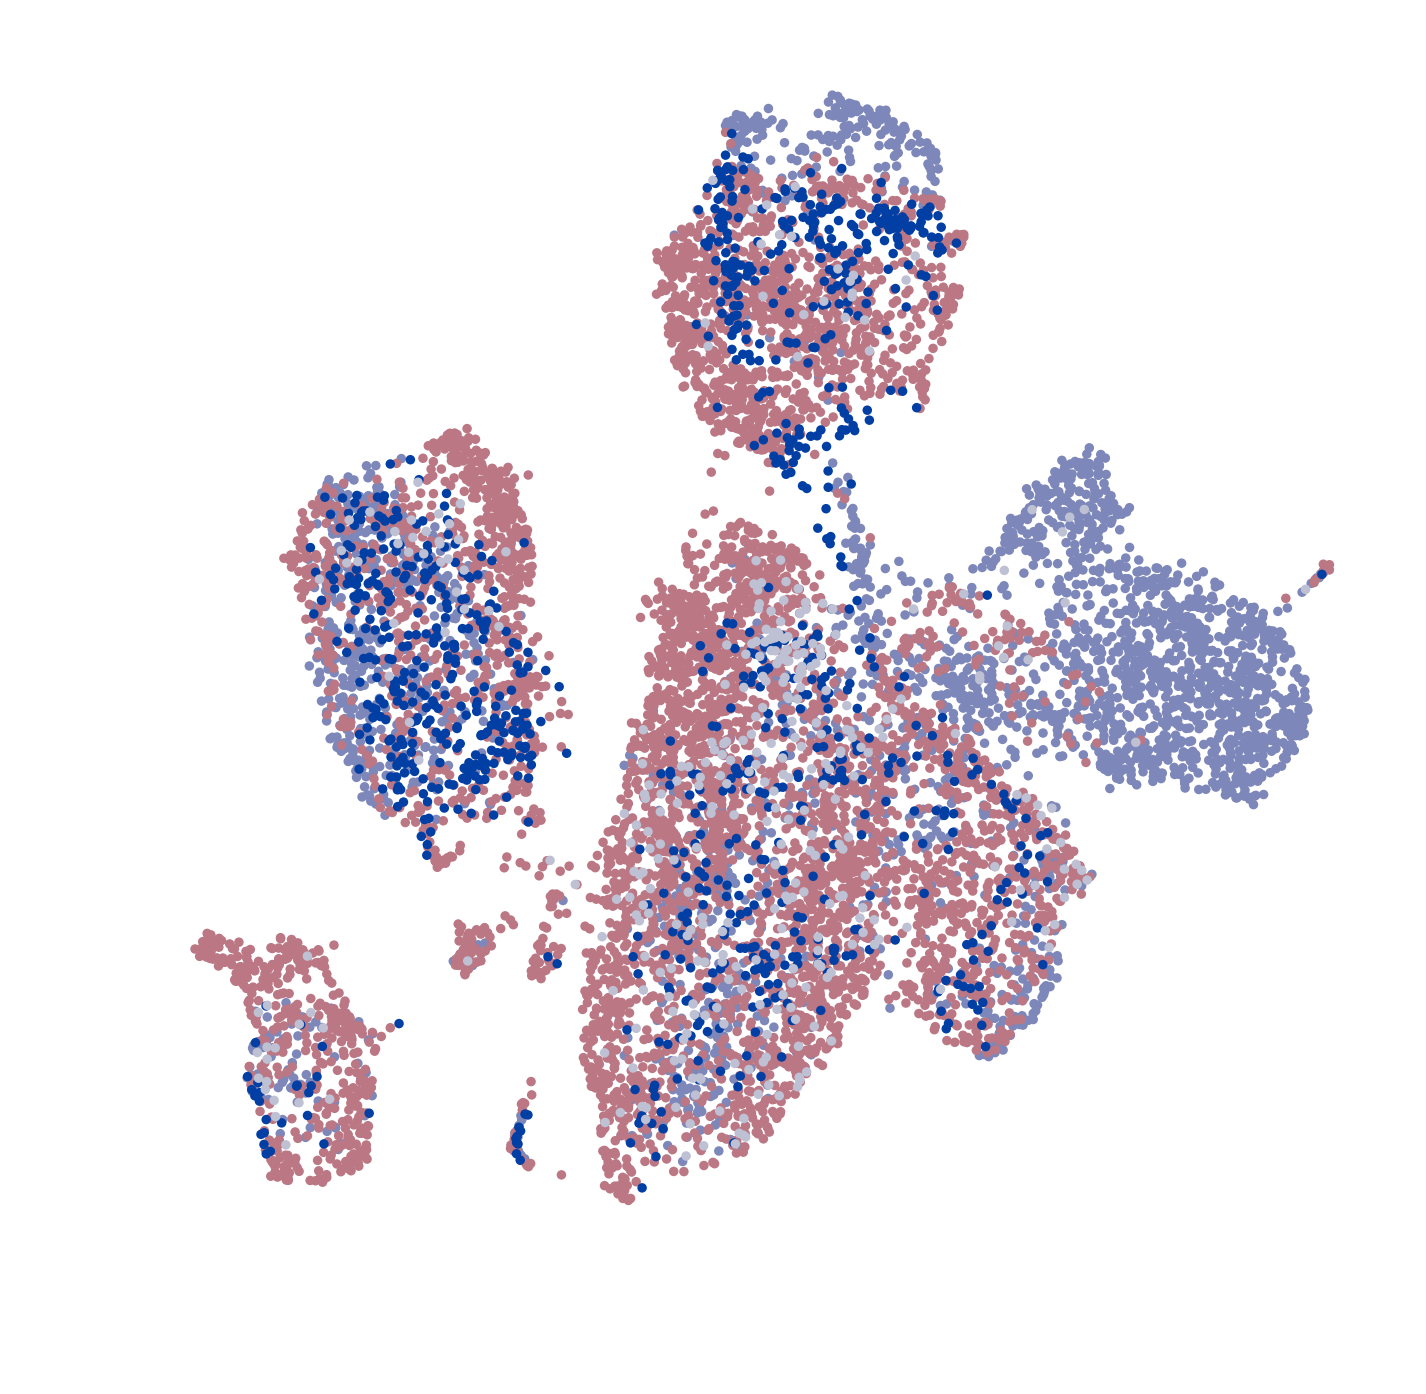

In [39]:
sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", legend_loc=None,
           save="_condition_after_1.pdf", palette=palette)

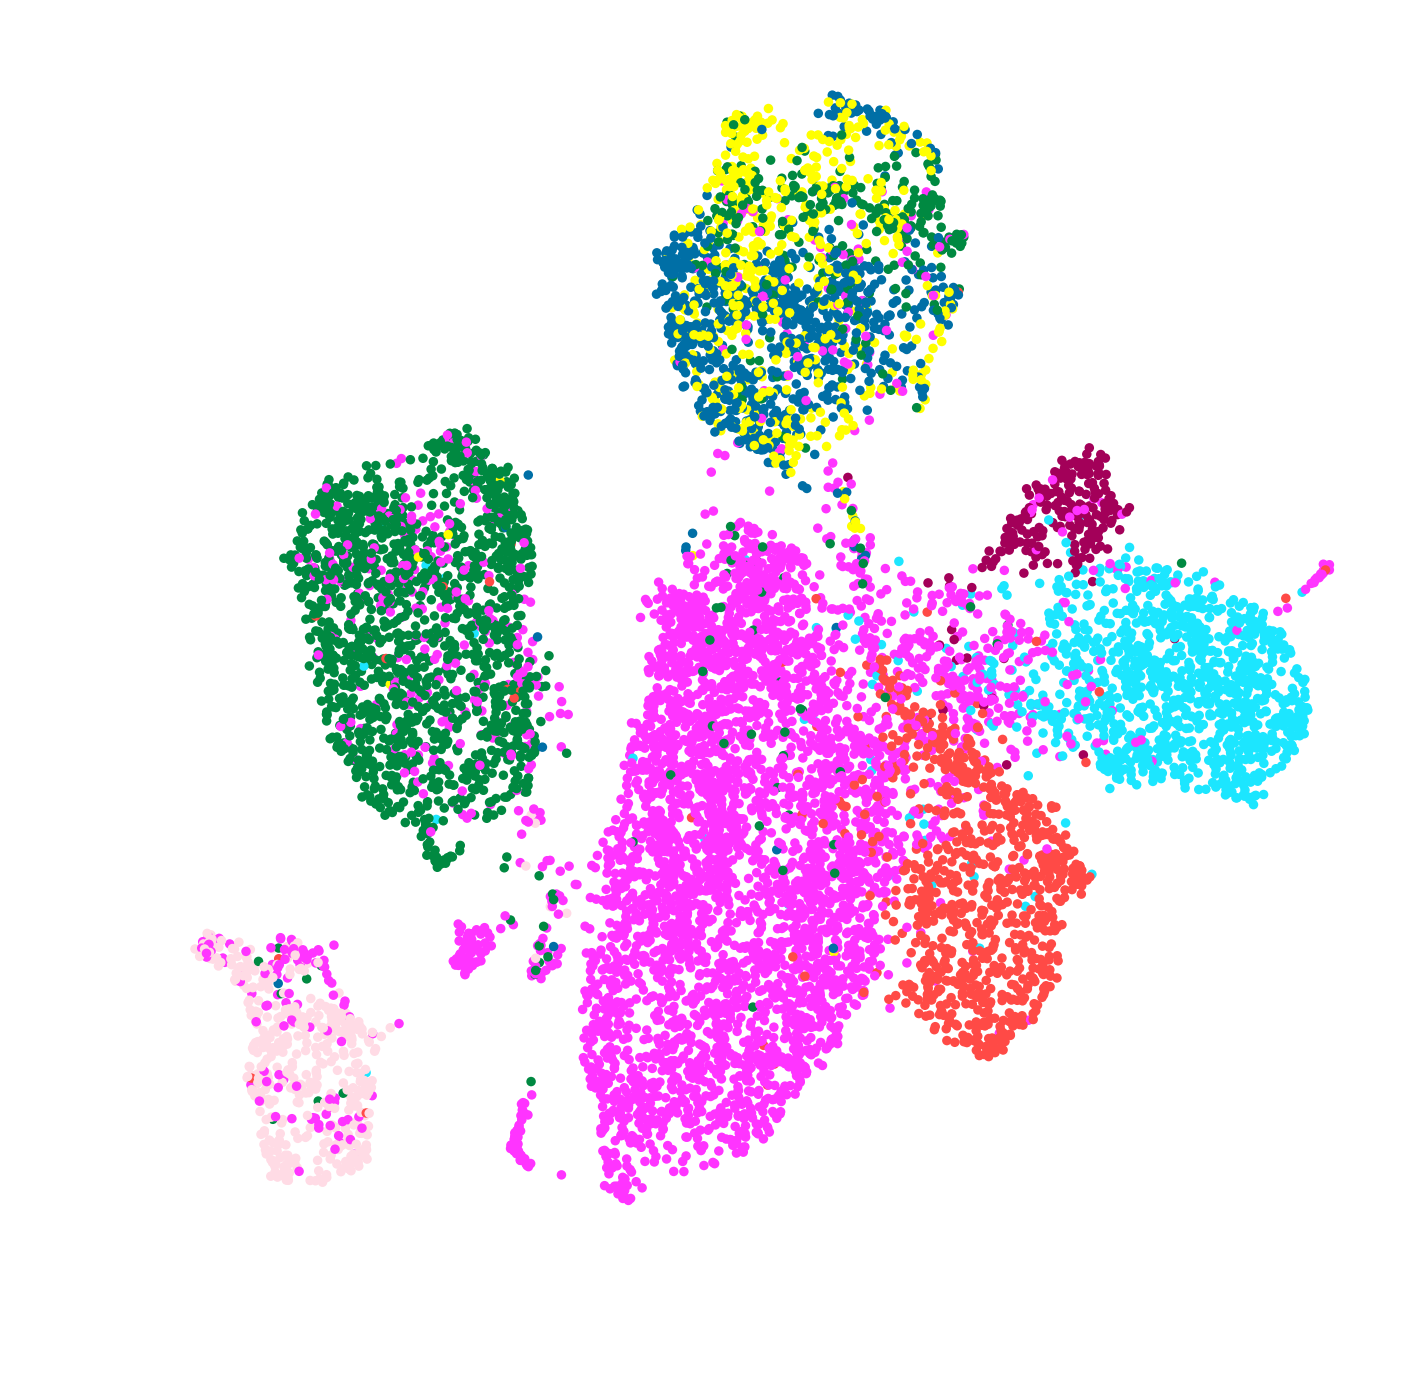

In [40]:
sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", legend_loc=None,
           save="_cell_type_after_1.pdf", palette=sc.pl.palettes.godsnot_102)

In [41]:
new_network = sn.operate(new_network, 
                         new_conditions=target_conditions[1],
                         init='Xavier',
                         freeze_expression_input=True,
                         freeze=True,
                         )

In [42]:
new_network.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq': 1,
 'Pancreas Fluidigm C1': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

In [43]:
target_adata = adata_out_of_sample[adata_out_of_sample.obs[condition_key] == target_conditions[1]]
target_adata

View of AnnData object with n_obs × n_vars = 2426 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [44]:
train_adata, valid_adata = sn.utils.train_test_split(target_adata, 0.8)

In [45]:
train_adata.shape, valid_adata.shape

((1940, 1000), (486, 1000))

In [46]:
new_network.model_path = f"./models/OoS+IS/pancreas/after-{target_conditions[1]}/"

In [47]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=128, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=False,
                  verbose=5)

Model has been successfully restored!


In [48]:
plot_adata = adata_for_training.concatenate(adata_out_of_sample)
plot_adata

AnnData object with n_obs × n_vars = 12678 × 1000 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [49]:
encoder_labels, _ = sn.utils.label_encoder(plot_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(12678, 1)

In [50]:
latent_adata = new_network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 12678 × 20 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [51]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [52]:
palette = batch_colors
palette

['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784']

... storing 'cell_type' as categorical
... storing 'study' as categorical


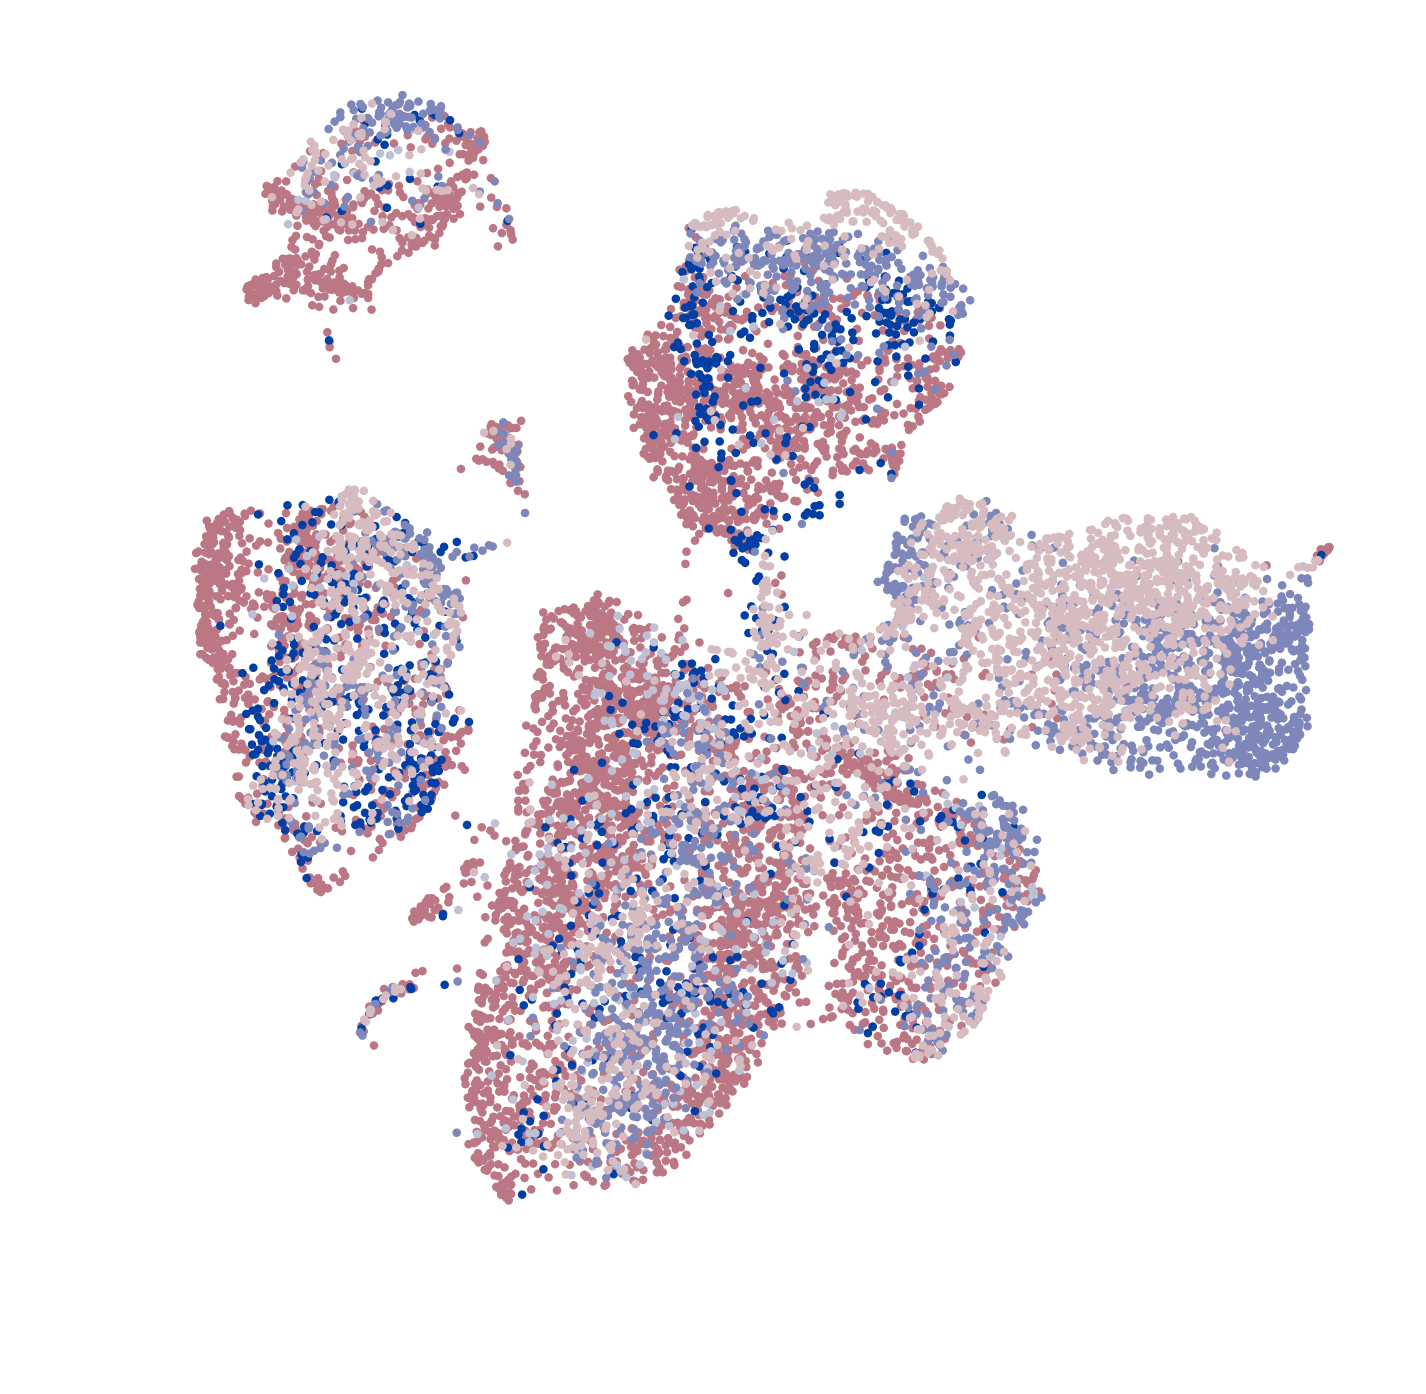

In [53]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", legend_loc=None,
           save="_condition_after_2.pdf", palette=palette)

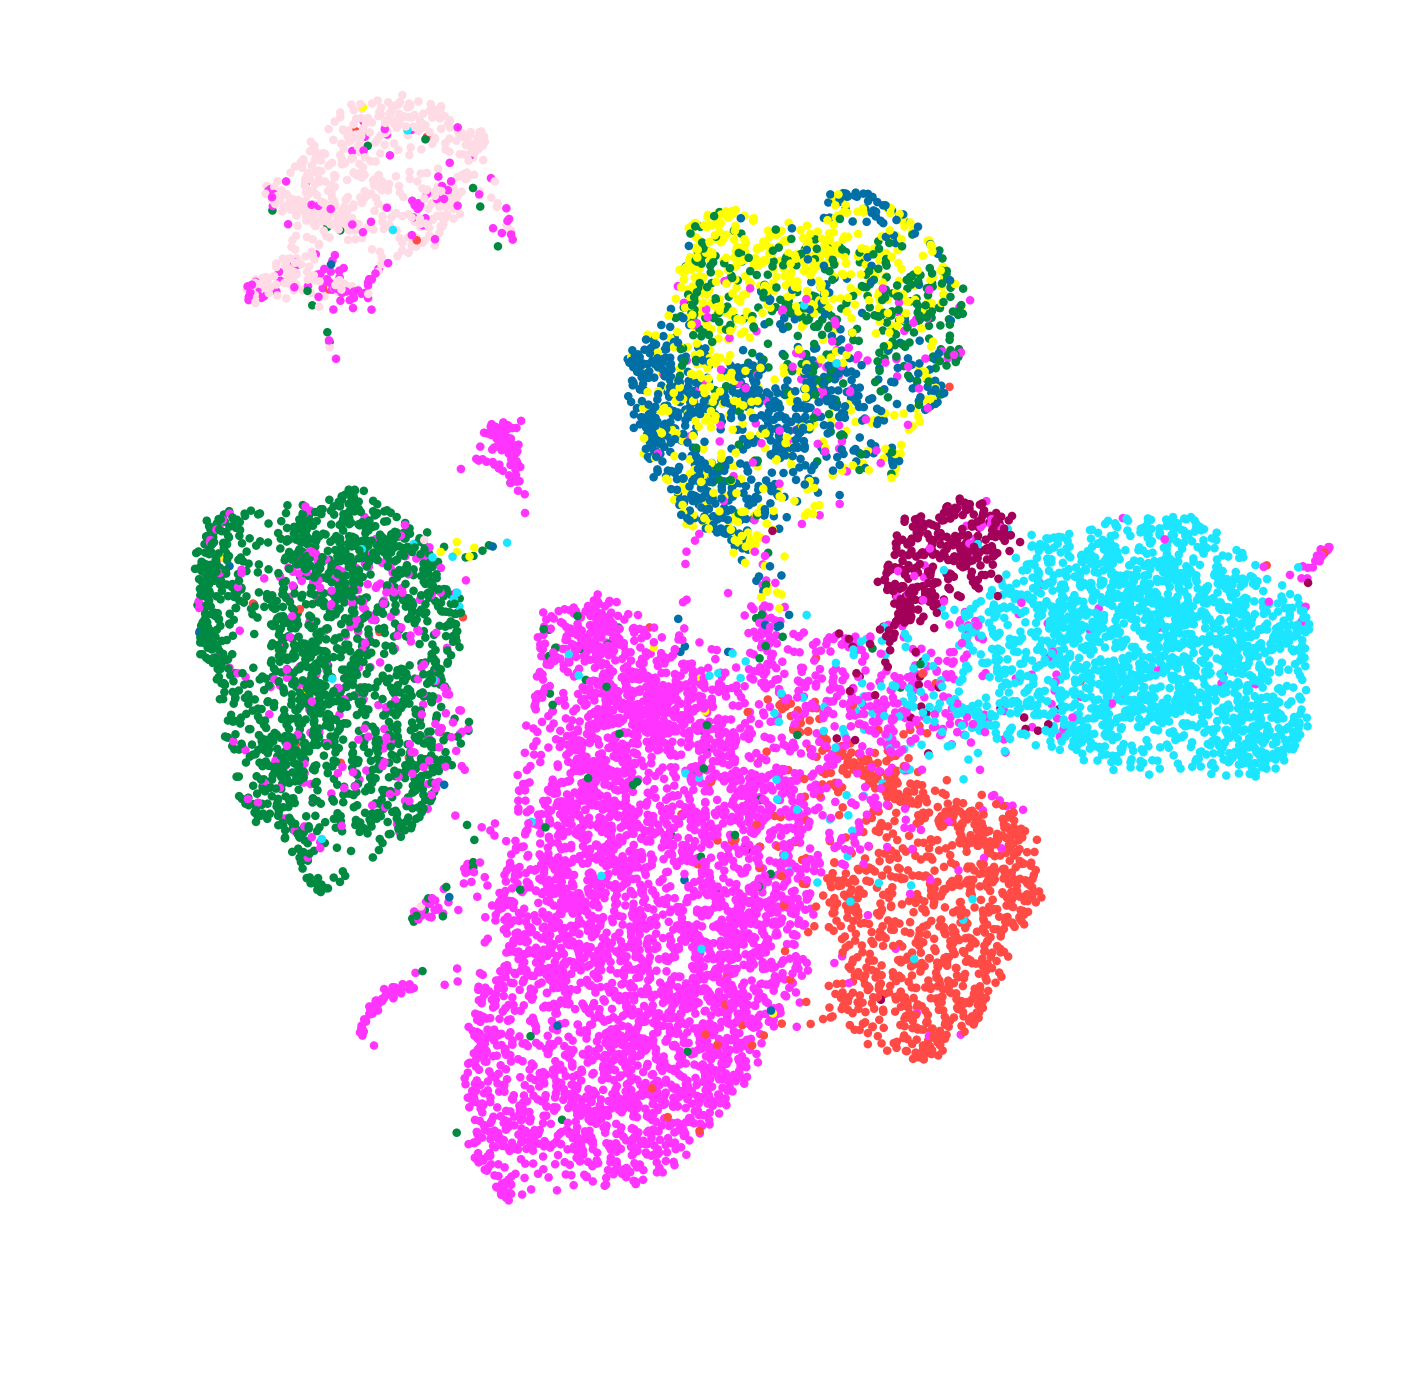

In [54]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", legend_loc=None,
           save="_cell_type_after_2.pdf", palette=sc.pl.palettes.godsnot_102)